# **전착도장 설비 예지보전 모델**

# 1. 데이터 불러오기

In [6]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/AIVLE/BigProject/EcoatingDataset.csv')

In [8]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('LOT')

# 모든 수치형 컬럼에 10을 곱하기
df[numeric_cols] = df[numeric_cols] * 10

print(df.head())

   LOT  Thick  PT_jo_V_1  PT_jo_A_Main_1  PT_jo_TP
0    1   22.6      294.0            96.0      34.0
1    2   22.6      283.0            39.0      34.0
2    3   22.6      283.0            27.0      34.0
3    4   22.6      283.0            21.0      34.0
4    5   22.1      283.0            96.0      34.0


### (선택) 모델 저장

In [ ]:
# (선택) 모델 저장

save_path = "/content/drive/MyDrive/AIVLE/BigProject/"

import joblib

# 저장 경로
model_path = save_path + "Ecoating_model.pkl"

# 저장
joblib.dump(best_model, model_path)

['/content/drive/MyDrive/AIVLE/BigProject/Ecoating_model.pkl']

In [ ]:
pip freeze

absl-py==1.4.0
accelerate==1.9.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.14
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.22.0
astropy==7.1.0
astropy-iers-data==0.2025.7.21.0.41.39
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.11.0
bigquery-magics==0.10.1
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.6.1
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
Brotli==1.1.0
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.7.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.90
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake=

# 2. EDA

- 인덱스 제거




In [9]:
df = df.drop(columns=['LOT'])

print(df.head())

   Thick  PT_jo_V_1  PT_jo_A_Main_1  PT_jo_TP
0   22.6      294.0            96.0      34.0
1   22.6      283.0            39.0      34.0
2   22.6      283.0            27.0      34.0
3   22.6      283.0            21.0      34.0
4   22.1      283.0            96.0      34.0


- 이상치 제거

In [10]:
# 전류 10A 미만 값 제거
df = df[df['PT_jo_A_Main_1'] > 10]

# IQR 기준 이상치 제거
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

df = remove_outliers_iqr(df, 'Thick')

- 결측치 확인

In [11]:
# 결측치 확인
df.isnull().sum()

,0
Thick,0
PT_jo_V_1,0
PT_jo_A_Main_1,0
PT_jo_TP,0


- 전처리된 데이터 셋 정보 확인

In [ ]:
# 기본 정보 확인
print("데이터셋 정보\n")
display(df.info())
print("\n\n데이터셋 구성\n")
print(df.describe())

데이터셋 정보

<class 'pandas.core.frame.DataFrame'>
Index: 16391 entries, 0 to 16729
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Thick           16391 non-null  float64
 1   PT_jo_V_1       16391 non-null  float64
 2   PT_jo_A_Main_1  16391 non-null  float64
 3   PT_jo_TP        16391 non-null  float64
dtypes: float64(4)
memory usage: 640.3 KB


None



데이터셋 구성

              Thick     PT_jo_V_1  PT_jo_A_Main_1      PT_jo_TP
count  16391.000000  16391.000000    16391.000000  16391.000000
mean      24.469074    260.218352       95.380331     33.567018
std        2.482800     30.533511       63.846462      0.640990
min       17.300000    159.000000       11.000000     32.000000
25%       22.600000    233.000000       46.000000     33.000000
50%       24.300000    279.000000       81.000000     34.000000
75%       26.400000    280.000000      128.000000     34.000000
max       31.900000    300.000000      326.000000     35.000000


- Pearson 상관 계수

                   Thick  PT_jo_V_1  PT_jo_A_Main_1  PT_jo_TP
Thick           1.000000   0.632076        0.253757  0.039508
PT_jo_V_1       0.632076   1.000000        0.343302  0.136591
PT_jo_A_Main_1  0.253757   0.343302        1.000000  0.073937
PT_jo_TP        0.039508   0.136591        0.073937  1.000000


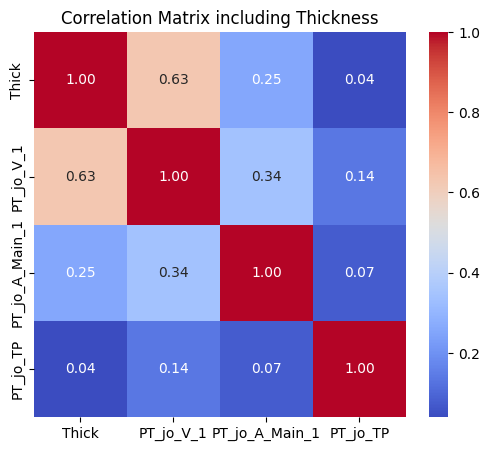

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
print(corr_matrix)

# 히트맵 출력
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix including Thickness")
plt.show()


- 주성분 분석 (PCA)

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 특성 선택 및 정규화
X = df[['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']]
X_scaled = StandardScaler().fit_transform(X)

# 2. PCA 수행
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# 3. 로딩 행렬 정리 (DataFrame으로 변환)
loadings = pd.DataFrame(
    pca.components_.T,  # 전치하여 변수 기준으로 정렬
    index=['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP'],
    columns=['PC1', 'PC2', 'PC3']
)

# 4. 소수점 6자리까지 보기 원하면:
pd.set_option("display.precision", 6)

# 5. 결과 출력
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("\nPCA Loadings:\n", loadings)

Explained variance ratio: [0.46639584 0.31676545 0.21683871]

PCA Loadings:
                      PC1       PC2       PC3
PT_jo_V_1       0.676676 -0.149217  0.721002
PT_jo_A_Main_1  0.647025 -0.346822 -0.679024
PT_jo_TP        0.351382  0.925985 -0.138139


### (옵션) Isolation Forest 기반 이상치 제거

- 오히려 떨어지는 성능


In [ ]:
from sklearn.ensemble import IsolationForest

# 입력 피처만 사용
X = df[['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']]

# 모델 생성 및 학습
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_pred = iso_forest.fit_predict(X)  # 1: 정상, -1: 이상치

# 이상치 필터링
df = df[outlier_pred == 1].copy()

### (옵션) LOF 기반 이상치 제거

- 성능 오히려 하락




In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# 정규화 (LOF는 스케일에 민감함)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']])

# LOF 모델 적용
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
lof_pred = lof.fit_predict(X_scaled)  # 1: 정상, -1: 이상치

# 이상치 제거
df = df[lof_pred == 1].copy()

# 3. 모델링

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 타겟 변수와 입력 변수 정의
y = df['Thick']
X = df[['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']]

# 학습용/테스트용 데이터 분리 (랜덤 시드 고정)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## RandomForest

RMSE: 1.4967
R² Score: 0.6419

📌 Feature Importances:
PT_jo_V_1         0.655040
PT_jo_A_Main_1    0.269072
PT_jo_TP          0.075889
dtype: float64


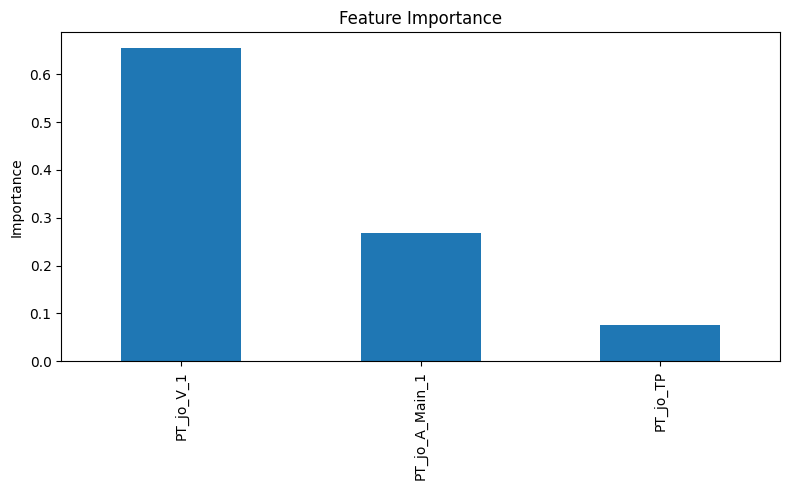

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤포레스트 모델 생성 및 학습
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

# 테스트 데이터에 대해 예측 수행
y_pred = model_rf.predict(X_test)

# 평가 지표 계산 (RMSE, R²)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 특성 중요도 출력 및 시각화 (옵션)
import matplotlib.pyplot as plt

feature_importance = pd.Series(model_rf.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

print("\n📌 Feature Importances:")
print(feature_importance)

feature_importance.plot(kind='bar', title='Feature Importance', figsize=(8,5))
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


### (추가) 온도(PT_jo_TP)가 없을때 성능 비교

In [ ]:
y = df['Thick']
X_base = df[['PT_jo_V_1', 'PT_jo_A_Main_1']]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_base, y, test_size=0.2, random_state=42)

model_a = RandomForestRegressor(random_state=42)
model_a.fit(X_train_a, y_train_a)

y_pred_a = model_a.predict(X_test_a)

rmse_a = np.sqrt(mean_squared_error(y_test_a, y_pred_a))
r2_a = r2_score(y_test_a, y_pred_a)

print("온도 제외 모델\n")
print(f"RMSE : {rmse_a:.4f}")
print(f"R² Score : {r2_a:.4f}")

온도 제외 모델

RMSE : 1.6374
R² Score : 0.5714


## XGBoost

✅ XGBoost RMSE: 1.5503
✅ XGBoost R² Score: 0.6157


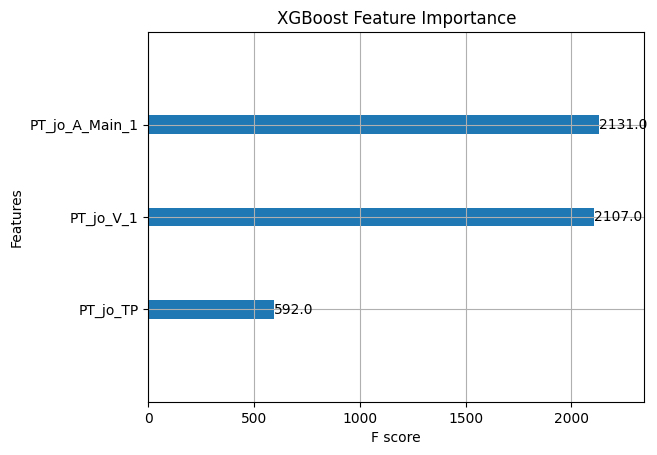

In [ ]:
import xgboost as xgb

# XGBoost 회귀 모델 생성 및 학습
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model_xgb.fit(X_train, y_train)

# 테스트 데이터에 대해 예측 수행
y_pred = model_xgb.predict(X_test)

# 평가 지표 계산 (RMSE, R²)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ XGBoost RMSE: {rmse:.4f}")
print(f"✅ XGBoost R² Score: {r2:.4f}")

# 특성 중요도 시각화 (옵션)
xgb.plot_importance(model_xgb)
plt.title('XGBoost Feature Importance')
plt.show()

## LightGBM

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.60397
✅ LightGBM RMSE: 1.6040
✅ LightGBM R² Score: 0.5887


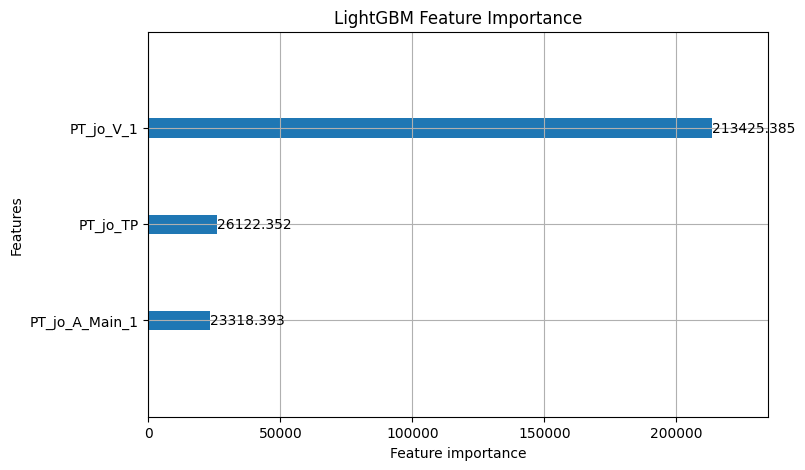

In [ ]:
import lightgbm as lgb

# LightGBM용 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# 파라미터 설정 (기본)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_seed': 42,
    'verbosity': -1
}

# 모델 학습
model_lgbm = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
)

# 예측
y_pred = model_lgbm.predict(X_test)

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ LightGBM RMSE: {rmse:.4f}")
print(f"✅ LightGBM R² Score: {r2:.4f}")

# 특성 중요도 시각화
lgb.plot_importance(model_lgbm, max_num_features=10, importance_type='gain', figsize=(8,5))
plt.title('LightGBM Feature Importance')
plt.show()

## 딥러닝 (Multi-Layer Perceptron, MLP)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 데이터 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 구성
model_dl = Sequential([
    Input(shape=(3,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# 컴파일
model_dl.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

# 학습
history = model_dl.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                    validation_split=0.2, verbose=0)

# 예측 및 평가
y_pred = model_dl.predict(X_test_scaled).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ MLP RMSE: {rmse:.4f}")
print(f"✅ MLP R² Score: {r2:.4f}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ MLP RMSE: 1.7598
✅ MLP R² Score: 0.5049


- (추가) 딥러닝 고도화

In [ ]:
# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 모델 구성
model_dl_a = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# 컴파일
model_dl_a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 학습
history = model_dl_a.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# 예측
y_pred = model_dl_a.predict(X_test).flatten()

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ 개선된 MLP RMSE: {rmse:.4f}")
print(f"✅ 개선된 MLP R² Score: {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ 개선된 MLP RMSE: 1.6879
✅ 개선된 MLP R² Score: 0.5445


## CatBoost Regressor

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

# CatBoost 모델 생성 및 학습
# CatBoost는 기본적으로 범주형 피처를 자동으로 처리하지만, 현재 피처는 모두 수치형이므로 별도 설정 불필요
model_catboost = CatBoostRegressor(random_state=42, verbose=0) # verbose=0으로 학습 과정 출력 숨김
model_catboost.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred_catboost = model_catboost.predict(X_test)

# 성능 평가
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)

print("✅ CatBoost Regressor 성능")
print(f"RMSE: {rmse_catboost:.4f}")
print(f"R² Score: {r2_catboost:.4f}")

# CatBoost Feature Importance (선택 사항)
print("\n📌 Feature Importances:")
for feature, importance in zip(X_train.columns, model_catboost.get_feature_importance()):
    print(f"{feature}: {importance:.4f}")

✅ CatBoost Regressor 성능
RMSE: 1.5831
R² Score: 0.5993

📌 Feature Importances:
PT_jo_V_1: 62.8099
PT_jo_A_Main_1: 19.3441
PT_jo_TP: 17.8460


## Support Vector Regressor (SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler # SVR은 스케일링에 민감

# SVR을 위해 데이터 스케일링
scaler_svr = StandardScaler()
X_train_scaled_svr = scaler_svr.fit_transform(X_train)
X_test_scaled_svr = scaler_svr.transform(X_test)

# SVR 모델 생성 및 학습
# 커널은 'rbf'를 기본으로 사용하며, C와 epsilon 하이퍼파라미터 튜닝 필요 가능
model_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1) # 기본 하이퍼파라미터
model_svr.fit(X_train_scaled_svr, y_train)

# 테스트 데이터 예측
y_pred_svr = model_svr.predict(X_test_scaled_svr)

# 성능 평가
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print("✅ Support Vector Regressor (SVR) 성능")
print(f"RMSE: {rmse_svr:.4f}")
print(f"R² Score: {r2_svr:.4f}")

✅ Support Vector Regressor (SVR) 성능
RMSE: 1.7525
R² Score: 0.5090


## K-Nearest Neighbors Regressor (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler # KNN도 스케일링에 민감

# 데이터 스케일링
scaler_knn = StandardScaler()
X_train_scaled_knn = scaler_knn.fit_transform(X_train)
X_test_scaled_knn = scaler_knn.transform(X_test)

try:
    X_train_scaled_svr
    X_test_scaled_svr
    X_train_scaled_knn = X_train_scaled_svr
    X_test_scaled_knn = X_test_scaled_svr
except NameError:
     scaler_knn = StandardScaler()
     X_train_scaled_knn = scaler_knn.fit_transform(X_train)
     X_test_scaled_knn = scaler_knn.transform(X_test)


# KNN 모델 생성 및 학습
# n_neighbors 하이퍼파라미터 튜닝 필요 가능
model_knn = KNeighborsRegressor(n_neighbors=5) # 기본 n_neighbors=5
model_knn.fit(X_train_scaled_knn, y_train)

# 테스트 데이터 예측
y_pred_knn = model_knn.predict(X_test_scaled_knn)

# 성능 평가
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print("✅ K-Nearest Neighbors Regressor (KNN) 성능")
print(f"RMSE: {rmse_knn:.4f}")
print(f"R² Score: {r2_knn:.4f}")

✅ K-Nearest Neighbors Regressor (KNN) 성능
RMSE: 1.6153
R² Score: 0.5829


## **모델 별 성능**

1. RandomForest ✅

*   RMSE: 0.1498
*   R² Score: 0.6413

2. XGBoost

*   RMSE: 0.1550
*   R² Score: 0.6157

3. LightGBM

*   RMSE: 0.1604
*   R² Score: 0.5887

4. MLP

*   RMSE: 0.1698
*   R² Score: 0.5393

5. CatBoost Regressor

*   RMSE: 1.5831
*   R² Score: 0.5993

6. Support Vector Regressor

*   RMSE: 1.7525
*   R² Score: 0.5090

7. K-Nearest Neighbors Regressor

*   RMSE: 1.6153
*   R² Score: 0.5829


# 하이퍼파라미터 튜닝

## 하이퍼파라미터 설정 (GridSearchCV)

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# 모델 정의
rf = RandomForestRegressor(random_state=42)

# GridSearchCV로 탐색
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

# 학습
grid_search.fit(X_train, y_train)

# 결과
best_model = grid_search.best_estimator_
print("최적 하이퍼파라미터:", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
최적 하이퍼파라미터: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### (옵션) Optuna

GridSearchCV 대신 Optuna로 하이퍼 파라미터를 찾고 모델링 시켰지만 성능 오히려 하락함

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.0 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    model = RandomForestRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3).mean()
    return score  # MSE는 음수로 반환됨

study = optuna.create_study(direction="maximize")  # score는 neg-MSE이므로 maximize
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)


[I 2025-07-24 05:26:24,819] A new study created in memory with name: no-name-acbb2a97-4d0f-4569-8985-e3552674448f
[I 2025-07-24 05:26:45,982] Trial 0 finished with value: -2.423691317456861 and parameters: {'n_estimators': 484, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: -2.423691317456861.
[I 2025-07-24 05:26:58,236] Trial 1 finished with value: -2.315516207059945 and parameters: {'n_estimators': 261, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: -2.315516207059945.
[I 2025-07-24 05:27:19,659] Trial 2 finished with value: -2.328717924646813 and parameters: {'n_estimators': 380, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: -2.315516207059945.
[I 2025-07-24 05:27:32,476] Trial 3 finished with value: -2.4181858916355914 and parameters: {'n_estimators': 489, 'max_depth': 25, 

Best hyperparameters: {'n_estimators': 128, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}


## 최적 하이퍼파라미터로 모델 재학습

In [19]:
from sklearn.ensemble import RandomForestRegressor

# 최적 하이퍼파라미터로 모델 정의
# 최적 모델 RandomForestRegressor
best_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# 학습
best_model.fit(X_train, y_train)

# 예측
y_pred = best_model.predict(X_test)

def regression_accuracy(y_true, y_pred, tolerance):
    # 실제값 기준 10% 오차 범위 계산
    lower_bound = y_true * (1 - tolerance)
    upper_bound = y_true * (1 + tolerance)

    # 범위 내에 있는 예측값 비율 계산
    accurate = np.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)
    accuracy = np.mean(accurate)

    return accuracy

# 사용 예
acc = regression_accuracy(y_test, y_pred, tolerance=0.1)
print(f"🎯 10% tolerance accuracy: {acc * 100:.2f}%")

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ 최적 모델 성능")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

🎯 10% tolerance accuracy: 89.63%
✅ 최적 모델 성능
RMSE: 1.4885
R² Score: 0.6458


# 모델 시각화

- 예측값 - 실제값 산점도

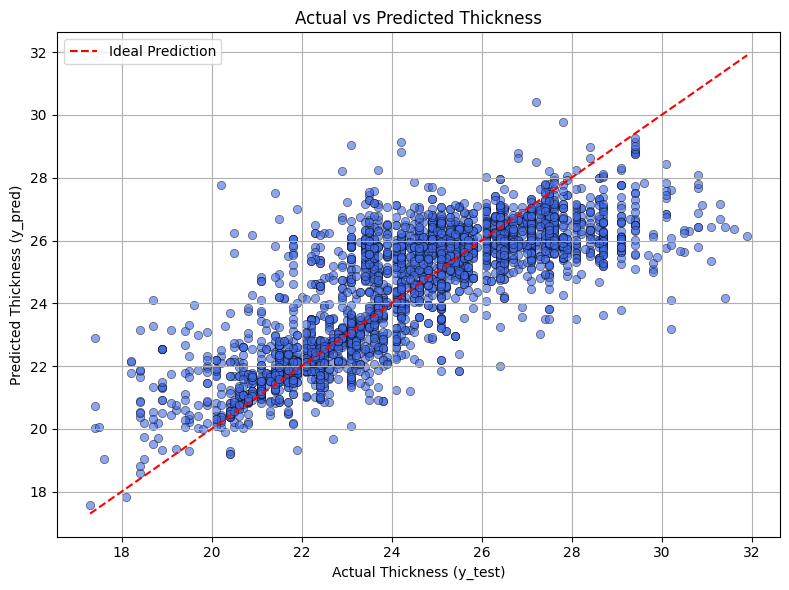

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값
y_pred = best_model.predict(X_test)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6, edgecolor='k')

# 기준선 (완벽한 예측일 때의 직선)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction')

plt.xlabel("Actual Thickness (y_test)")
plt.ylabel("Predicted Thickness (y_pred)")
plt.title("Actual vs Predicted Thickness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- 잔차(residuals) 분석

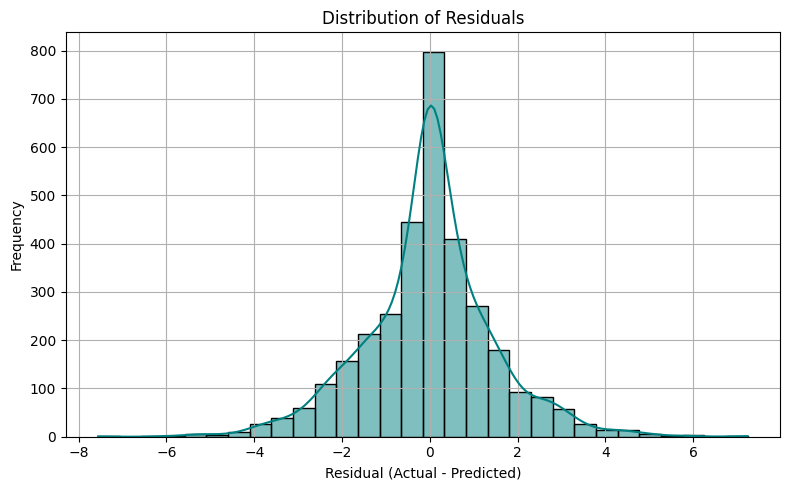

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값
y_pred = best_model.predict(X_test)

# 잔차 계산
residuals = y_test - y_pred

# 잔차 분포 확인 (히스토그램 + 커널 밀도)
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='teal', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 이상 원인 분석 (SHAP)

- 각 피처(feature)가 예측 결과에 어떤 영향을 미쳤는지 정량적으로 보여주는 도구
- 예측값이 기준값(=평균 예측값)에서 얼마나 벗어났는지, 그리고 그 벗어나는 데 각 피처가 얼마만큼 기여했는지 알수있음

In [ ]:
# 예측값
y_pred = best_model.predict(X_test)

# 오차 비율 계산
error_ratio = np.abs((y_test - y_pred) / y_test)

# 이상값 조건: 예측 오차가 10% 이상
anomalies = error_ratio > 0.1

# 이상값 중 첫 번째 샘플 인덱스 (테스트용)
anomaly_index = np.where(anomalies)[0][0]

# 이상값 샘플 추출
x_anomaly = X_test.iloc[[anomaly_index]]


In [ ]:
# SHAP 분석 예시 시각화 및 시뮬레이션용 이상값 샘플
x_anomaly

,PT_jo_V_1,PT_jo_A_Main_1,PT_jo_TP
156,285.0,32.0,34.0


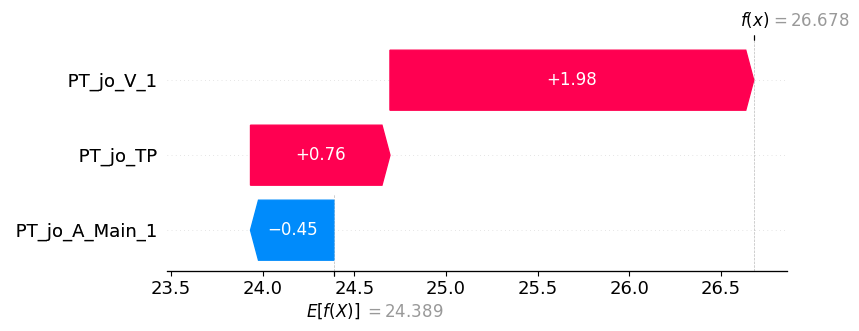

In [ ]:
import shap

# explainer 정의
explainer = shap.TreeExplainer(best_model, data=X_train)

# SHAP 값 계산 (단일 샘플)
shap_values = explainer.shap_values(x_anomaly)

# waterfall plot (예상값, SHAP 값, 원본 값)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,      # 첫 번째 expected_value만 사용
    shap_values[0],                   # 첫 번째 샘플에 대한 SHAP 값
    x_anomaly.iloc[0]                 # 첫 번째 샘플의 입력값
)

- 두께의 예측 오차가 10%을 넘었을때 각 feature의 기여도를 나타냄
- 여기서는 전압의 과다(+1.98)가 가장 큰 원인

## 임계값(shap_thredshold) 설정

In [ ]:
import numpy as np
import pandas as pd

# 예측 오차 10% 이상인 이상치 샘플 식별
X_anomaly = X_test[anomalies]
y_anomaly = y_test[anomalies] # 이상치 실제 값도 저장
error_indices = y_anomaly.index.tolist() # 이상치 원본 인덱스 저장

# 식별된 이상치 샘플에 대한 SHAP 값 계산
shap_values_anomaly = explainer(X_anomaly)

# 각 이상치 샘플별 SHAP sum 계산
shap_sums_anomaly = [np.sum(np.abs(val)) for val in shap_values_anomaly.values]

 98%|===================| 333/340 [00:49<00:01]       

분석 대상 이상치 샘플 수: 340
사용할 SHAP threshold: 2.0


### 이상치 샘플 SHAP 합 분포 시각화 및 임계값 설정

여기서는 예측 오차가 10% 이상인 이상치 샘플들에 대해서만 SHAP 합을 계산하고, 그 분포를 시각화합니다. 이 분포를 보고 SHAP 기여도가 낮은 이상치(일반 기계 문제로 분류)와 SHAP 기여도가 높은 이상치(세부 원인 분류)를 나눌 임계값(`shap_threshold`)을 결정합니다.

히스토그램에서 SHAP 합이 집중된 구간과 꼬리 부분을 확인하고, 두 그룹을 구분하기에 적절한 값을 임계값으로 선택할 수 있습니다.

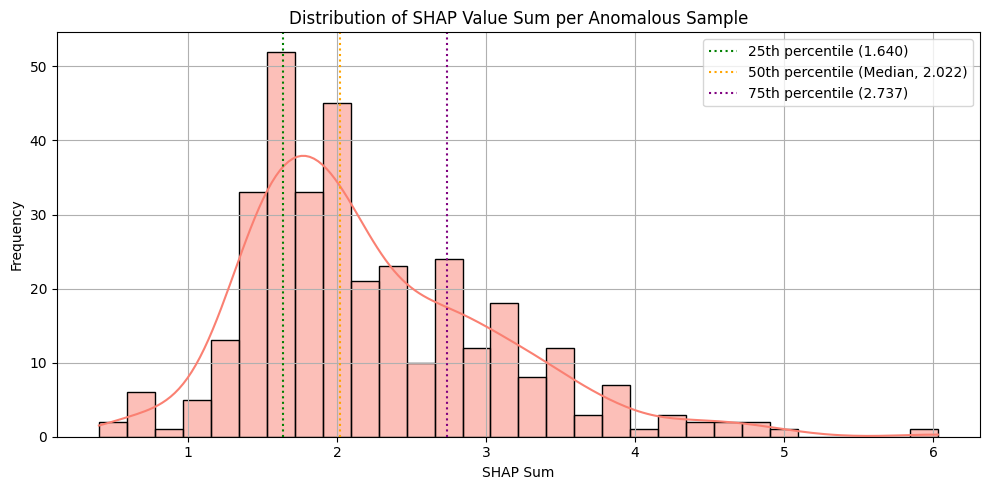

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화
plt.figure(figsize=(10, 5))
sns.histplot(shap_sums_anomaly, bins=30, kde=True, color='salmon')

# 분위수(예: 25%, 50%) 표시 (참고용)
quantiles = np.percentile(shap_sums_anomaly, [25, 50, 75])
plt.axvline(quantiles[0], color='green', linestyle=':', label=f'25th percentile ({quantiles[0]:.3f})')
plt.axvline(quantiles[1], color='orange', linestyle=':', label=f'50th percentile (Median, {quantiles[1]:.3f})')
plt.axvline(quantiles[2], color='purple', linestyle=':', label=f'75th percentile ({quantiles[2]:.3f})')

plt.title('Distribution of SHAP Value Sum per Anomalous Sample')
plt.xlabel('SHAP Sum')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 이상치 샘플들로 출력 Test

In [ ]:
# 결론 : 임계값을 2.0로 설정
shap_threshold = 2.0 # 이전 셀에서 정의된 shap_threshold 사용

# logs 기록
logs = []

# 이상치 샘플에 대해 계산된 SHAP 값과 합 사용
shap_array = shap_values_anomaly.values
feature_names = list(shap_values_anomaly.feature_names)
shap_sums = shap_sums_anomaly

# X_error_samples 대신 X_anomaly 사용
X_error_samples = X_anomaly
y_error_samples = y_anomaly # y_anomaly 사용

for i in range(len(X_error_samples)):
    row = X_error_samples.iloc[i]
    shap_row = shap_array[i]

    # SHAP 값의 절대값으로 각 특성의 기여도 크기 계산
    shap_dict = {f: abs(shap_row[feature_names.index(f)]) for f in ['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']}
    # SHAP 원본 값 (부호 포함) 저장하여 원인 판단에 사용
    shap_raw_dict = {f: shap_row[feature_names.index(f)] for f in ['PT_jo_V_1', 'PT_jo_A_Main_1', 'PT_jo_TP']}
    shap_sum = shap_sums[i] # 미리 계산된 SHAP 합 사용

    # 가장 큰 영향 요소
    main_cause = max(shap_dict, key=shap_dict.get)
    main_shap_value = shap_raw_dict[main_cause] # 원본 SHAP 값 사용

    # SHAP 합 임계값을 기준으로 세부 원인 코드 부여
    if shap_sum < shap_threshold:
        issue = "PAINT-EQUIP-MACHINE" # SHAP 기여도가 낮으면 일반 기계 문제로 판단
    else:
        if main_cause == 'PT_jo_V_1':
            issue = "PAINT-EQUIP-VOLTAGE-HIGH" if main_shap_value > 0 else "PAINT-EQUIP-VOLTAGE-LOW"
        elif main_cause == 'PT_jo_A_Main_1':
            issue = "PAINT-EQUIP-CURRENT-HIGH" if main_shap_value > 0 else "PAINT-EQUIP-CURRENT-LOW"
        elif main_cause == 'PT_jo_TP':
            issue = "PAINT-EQUIP-TEMPER-HIGH" if main_shap_value > 0 else "PAINT-EQUIP-TEMPER-LOW"
        else:
            issue = "PAINT-EQUIP-UNKNOWN" # 예상치 못한 경우

    logs.append({
        'Index': error_indices[i], # 원본 인덱스 사용
        'Voltage': row['PT_jo_V_1'],
        'Current': row['PT_jo_A_Main_1'],
        'Temp': row['PT_jo_TP'],
        'Actual_Thick': y_error_samples.iloc[i], # 실제 두께
        'Predicted_Thick': best_model.predict(pd.DataFrame([row]))[0], # 예측 두께 계산
        'SHAP_Sum': shap_sum, # SHAP 합 추가 (확인용)
        'Main_SHAP_Value': main_shap_value, # 주 원인 SHAP 값 추가 (확인용)
        'Issue_Code': issue
    })

log_df = pd.DataFrame(logs)
print(log_df)

     Index  Voltage  Current  Temp  Actual_Thick  Predicted_Thick  SHAP_Sum  \
0      156    285.0     32.0  34.0          21.5        26.678358  3.198359   
1     2413    279.0    116.0  33.0          23.7        26.348954  1.960324   
2    15316    289.0     45.0  34.0          22.7        25.179703  2.050788   
3      123    241.0     21.0  34.0          19.1        23.139360  1.304499   
4    11563    279.0    118.0  34.0          23.1        25.795311  1.550199   
..     ...      ...      ...   ...           ...              ...       ...   
335   2456    279.0     99.0  33.0          31.4        26.426174  2.037544   
336  13651    207.0     20.0  33.0          18.4        20.503747  3.884883   
337    223    283.0     22.0  34.0          19.9        22.207054  2.181576   
338   9743    278.0    162.0  33.0          29.4        26.336007  1.947377   
339    622    289.0    108.0  34.0          21.8        25.537755  1.856747   

     Main_SHAP_Value                Issue_Code  
0 